In [92]:
import sqlite3
import pandas
import geopandas
import matplotlib.pyplot as plt
import numpy as np
import homelocationdf
import geostatdf
import importlib
import regions
import populationdf
from shapely.geometry import Polygon

# Regions
We will look at homelocations from three perspectives; national, Gothenburg and Stockholm.

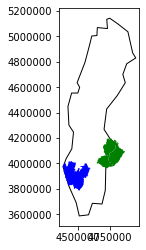

In [3]:
ax = regions.sweden.plot(facecolor='none', edgecolor='black')
regions.gothenburg.plot(ax=ax, color='blue')
regions.stockholm.plot(ax=ax, color='green')

# Homelocation

Home locations have been derived from geotagged tweets from each user in the timespans 8pm - 10am (not inclusive) on weekdays, and the entire weekend. These tweets have been clustered using DBSCAN with parameters eps = 100m and min_cluster_size = 2. From these clusters we pick the one with the most geotagged tweets.

For analysing the quality of the homelocations we also compute some descriptive statistics:
* **count** - number of tweets in cluster
* **percentage_total** - number of tweets in cluster / total number tweets in timespan (1=all, 0=none)
* **percentage_next** - number of tweets in second largest cluster / number of tweets in largest cluster (0=one large, 1=at least two same sized cluster)

In [4]:
homelocations_all = homelocationdf.load('sweloc')

,calc_name,user_id,type,latitude,longitude,count,percentage_total,percentage_next,radius_kilometers,geometry
0,sweloc,3271,home,37.773213,-122.447928,2,0.666667,0.000000,0.1,POINT (-122.44793 37.77321)
1,sweloc,5616,home,59.403225,17.955987,61,0.130064,0.704918,0.1,POINT (17.95599 59.40323)
2,sweloc,5976,home,56.053940,12.684570,5,0.075758,0.800000,0.1,POINT (12.68457 56.05394)
3,sweloc,6657,home,39.091586,-77.203932,3,0.100000,1.000000,0.1,POINT (-77.20393 39.09159)
4,sweloc,8981,home,59.317224,18.026986,72,0.314410,0.125000,0.1,POINT (18.02699 59.31722)


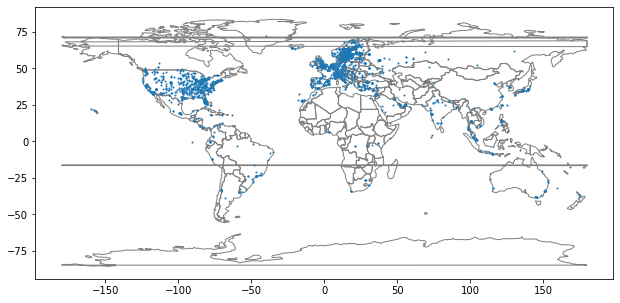

In [5]:
f, a = plt.subplots(figsize=(15,5))
regions.countries.to_crs(homelocations_all.crs).plot(ax=a, facecolor='none', edgecolor='grey')
homelocations_all.plot(ax=a, markersize=1)
homelocations_all.head()

In [58]:
def plothomelocations(hl):
    fig, ax = plt.subplots(2, 1, figsize=(15,10))
    sc1 = ax[0].scatter(
        hl['percentage_total'], 
        hl['count'],
        s=2, 
        c=hl['percentage_next'],
    )
    ax[0].set_xlabel('percentage_total')
    ax[0].set_ylabel('count')
    cb = plt.colorbar(sc1, ax=ax[0])
    cb.set_label('percentage_next')
    
    sc2 = ax[1].scatter(
        hl['percentage_total'], 
        hl['percentage_next'],
        s=2, 
    )
    ax[1].set_xlabel('percentage_total')
    ax[1].set_ylabel('percentage_total')

Without filtering out users which are predicted to live in Sweden, we find several users with a large amount of geotagged tweets at one location. This seems very unlikely, and indicates that these users are bot acounts.

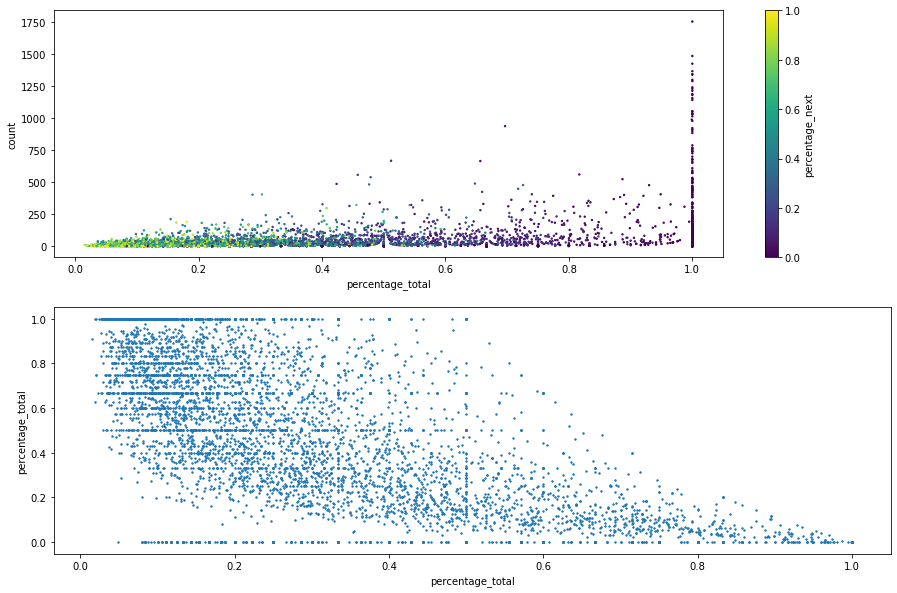

In [59]:
plothomelocations(homelocations_all)

In total there are 6745 homelocations derived (with varying quality, todo: define quality?). Out of those 3966 are within Sweden.

In [60]:
print(homelocations_all.shape)
homelocations = geopandas.clip(homelocations_all.to_crs(regions.sweden.crs), regions.sweden)
print(homelocations.shape)

(6745, 10)
(3966, 10)


After filtering out non-Swedish users from the homelocations, the number of accounts thought to be bot accounts decrease. 

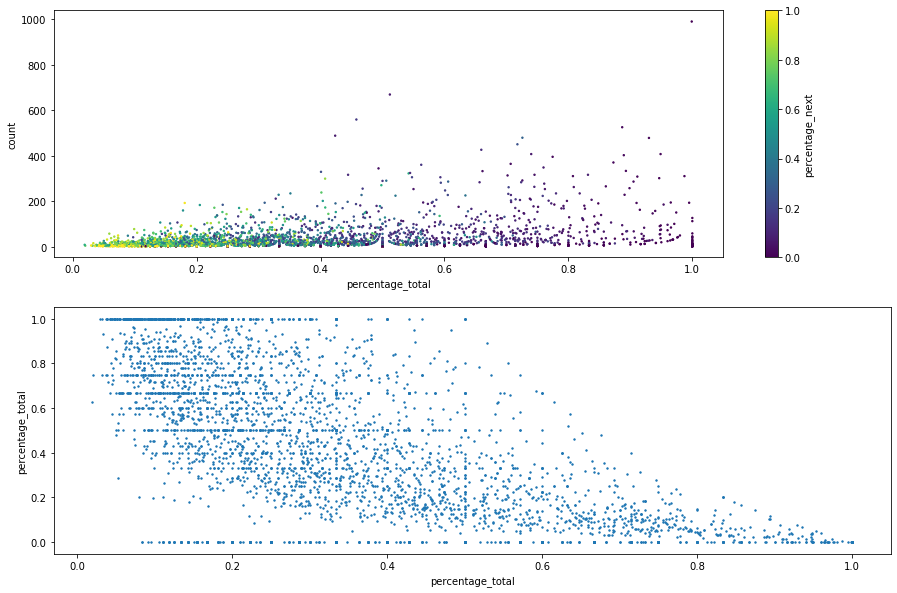

In [61]:
plothomelocations(homelocations)

## Population distribution

We expect the data from Twitter to be biased towards larger cities. By plotting all the swdish homelocations on a map this is generally confirmed.

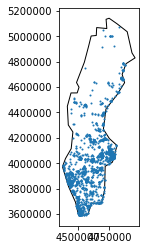

In [62]:
ax = regions.sweden.plot(facecolor='none', edgecolor='black')
homelocations.plot(ax=ax, markersize=1)

In [169]:
def plot_population(census, twitter, cmap='viridis', height=5, filter_zero=False, scale='population'):
    scaled_census = populationdf.rescale(census)
    scaled_twitter = populationdf.rescale(twitter)
    fig, axes = plt.subplots(1,2, figsize=(15,height), sharex=True, sharey=True)
    scaled_census.plot(ax=axes[0], column=scale, legend=True, legend_kwds={'label': scale }, cmap=cmap)
    scaled_twitter.plot(ax=axes[1], column=scale, legend=True, legend_kwds={'label': scale }, cmap=cmap)
    
def hist_population(census, twitter, scale='population', sharey=False):
    scaled_census = populationdf.rescale(census)
    scaled_twitter = populationdf.rescale(twitter)
    fig, axes = plt.subplots(1,2, figsize=(15,5), sharey=sharey)
    axes[0].hist(scaled_census[scale], log=True, bins=30)
    axes[1].hist(scaled_twitter[scale], log=True, bins=30)

In [29]:
national_geostat = geostatdf.load(mask=regions.sweden)
print(homelocations.shape)
national_homelocations = geostatdf.merge_home_location(national_geostat, homelocations)
print(national_homelocations.shape)

/Users/ericwennerberg/opt/miniconda3/envs/mscthesis/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3254: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


(3966, 10)
(1781, 3)


In [67]:
national_homelocations.head()

,GRD_ID,geometry,population,population_normal,population_pow
0,1kmN3985E4385,"POLYGON ((4385000.000 3985000.000, 4385000.000...",1,0.005495,0.000030
1,1kmN3981E4388,"POLYGON ((4388000.000 3981000.000, 4388000.000...",3,0.016484,0.000272
2,1kmN3959E4389,"POLYGON ((4389000.000 3959000.000, 4389000.000...",1,0.005495,0.000030
3,1kmN3983E4389,"POLYGON ((4389000.000 3983000.000, 4389000.000...",1,0.005495,0.000030
4,1kmN3958E4391,"POLYGON ((4391000.000 3958000.000, 4391000.000...",1,0.005495,0.000030


The grid system of GEOSTAT does not include squares where the estimated population is zero. This means that some derived homelocations are exluded because they don't fit within the existing squares.

In [66]:
print(homelocations['user_id'].count())
print(national_homelocations['population'].sum())

3966
3891


The distribution (not regarding location) of population levels are visually similar, however Twitter data is a lot more sparse.

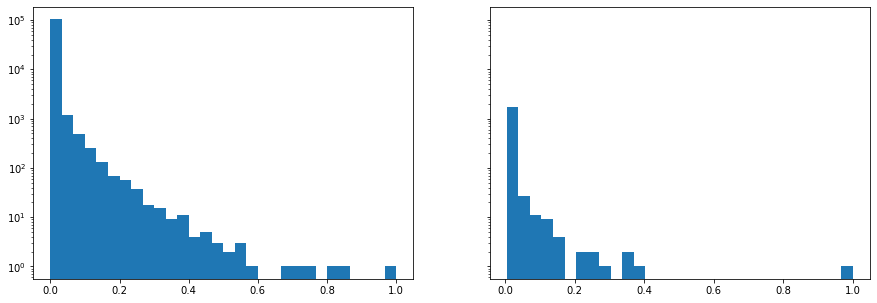

In [82]:
hist_population(national_geostat, national_homelocations, scale='population_normal', sharey=True)

### Nation-level

Looking at the spatial nation-level population distribution we confirm the bias towards larger cities. 

* Correlation scatter plot


(We should redo this with a grid system with larger grids)

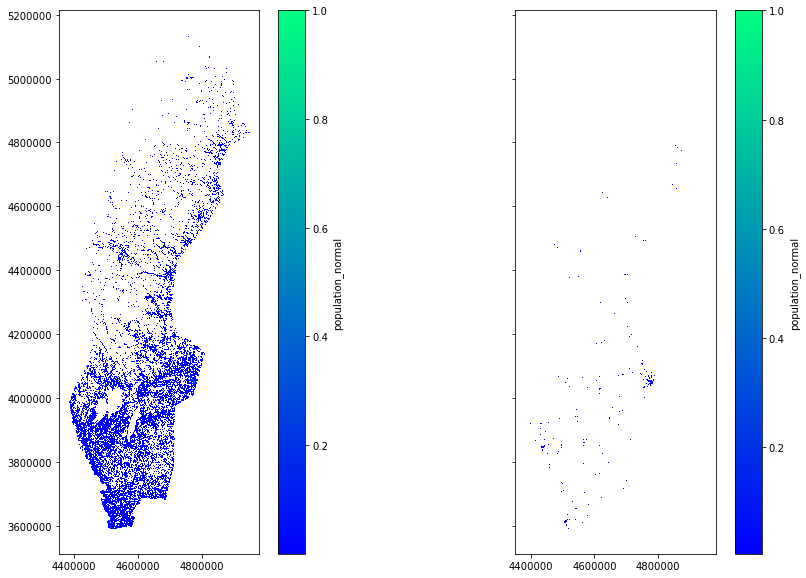

In [88]:
plot_population(national_geostat, national_homelocations, cmap='winter', height=10, scale='population_normal')

In [176]:
national_correlation = national_homelocations.merge(national_geostat, on='GRD_ID').sort_values('population_y')
national_correlation['representation'] = national_correlation['population_normal_x'] / national_correlation['population_normal_y']

Text(0, 0.5, 'Twitter derived homelocation')

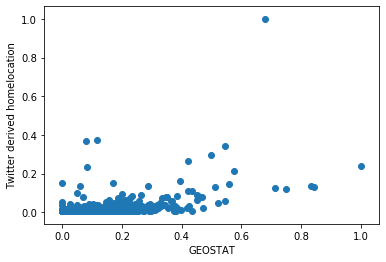

In [174]:
plt.scatter(national_correlation['population_normal_y'], national_correlation['population_normal_x'])
plt.xlabel('GEOSTAT')
plt.ylabel('Twitter derived homelocation')

### Gothenburg

In [78]:
gbg_geostat = geostatdf.load(mask=regions.gothenburg)
gbg_homelocations = geopandas.clip(homelocations, regions.gothenburg)
print(gbg_homelocations.shape)
gbg_homelocations = geostatdf.merge_home_location(gbg_geostat, gbg_homelocations)
print(gbg_homelocations.shape)

/Users/ericwennerberg/opt/miniconda3/envs/mscthesis/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3254: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


(637, 10)
(344, 3)


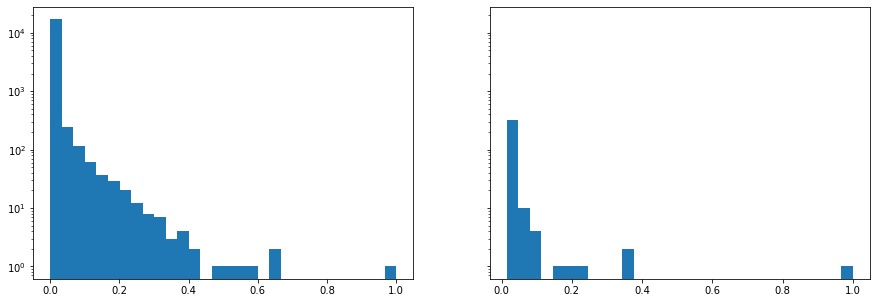

In [83]:
hist_population(gbg_geostat, gbg_homelocations, scale='population_normal', sharey=True)

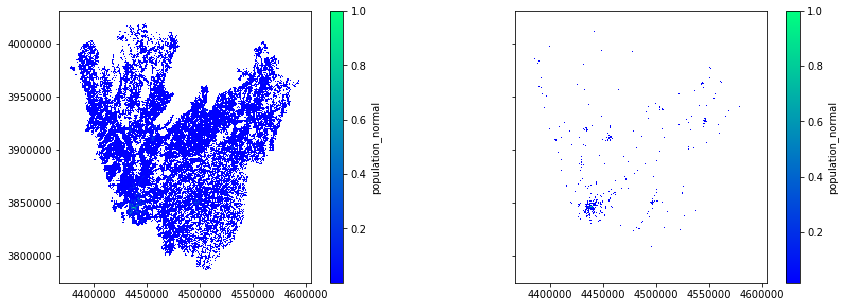

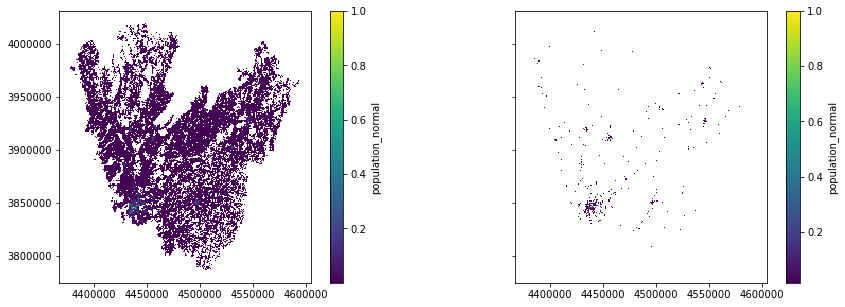

In [170]:
plot_population(gbg_geostat, gbg_homelocations, cmap='winter', scale='population_normal')
plot_population(gbg_geostat, gbg_homelocations, scale='population_normal')

#### Inner gothenburg

We zoom in on inner Gothenburg because it seems to have a lot more user homelocations, according to the plots above and our assumptions.

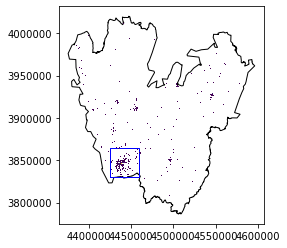

In [114]:
ax = regions.gothenburg.plot(facecolor='none', edgecolor='black')
regions.gbgcity.plot(ax=ax, facecolor='none', edgecolor='blue')
gbg_homelocations.plot(ax=ax, column='population_normal')


In [126]:
gbgcity_geostat = geostatdf.load(mask=regions.gbgcity)
gbgcity_homelocations = geopandas.clip(homelocations, regions.gbgcity)
print(gbgcity_homelocations.shape)
gbgcity_homelocations = geostatdf.merge_home_location(gbgcity_geostat, gbgcity_homelocations)
print(gbgcity_homelocations.shape)

/Users/ericwennerberg/opt/miniconda3/envs/mscthesis/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3254: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


(376, 10)
(146, 3)


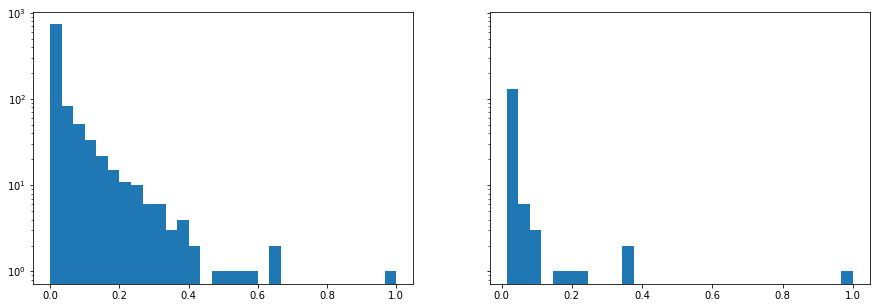

In [127]:
hist_population(gbgcity_geostat, gbgcity_homelocations, scale='population_normal', sharey=True)

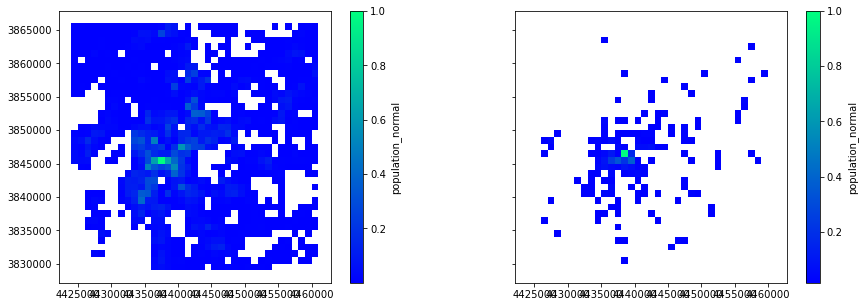

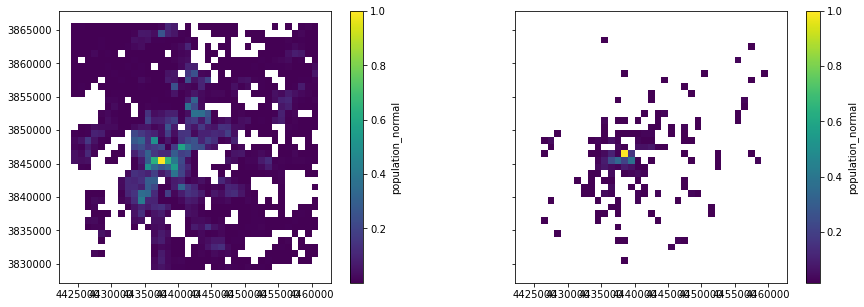

In [171]:
plot_population(gbgcity_geostat, gbgcity_homelocations, cmap='winter', scale='population_normal')
plot_population(gbgcity_geostat, gbgcity_homelocations, scale='population_normal')

### Stockholm

In [90]:
sthlm_geostat = geostatdf.load(mask=regions.stockholm)
sthlm_homelocations = geopandas.clip(homelocations, regions.stockholm)
sthlm_homelocations = geostatdf.merge_home_location(sthlm_geostat, sthlm_homelocations)

/Users/ericwennerberg/opt/miniconda3/envs/mscthesis/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3254: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


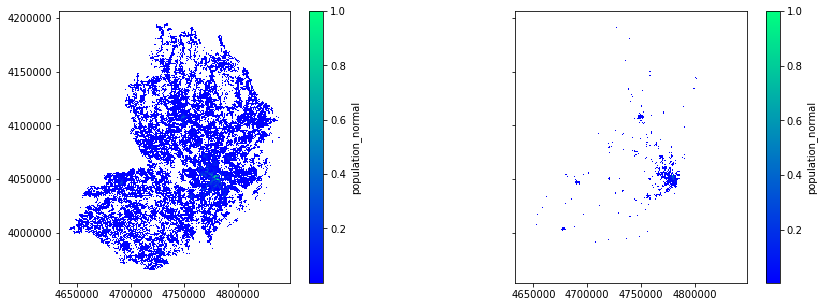

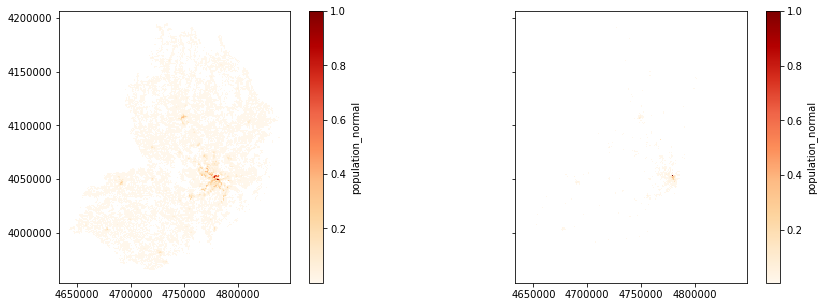

In [91]:
plot_population(sthlm_geostat, sthlm_homelocations, cmap='winter', scale='population_normal')
plot_population(sthlm_geostat, sthlm_homelocations, scale='population_normal')

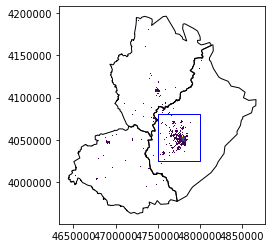

In [136]:
sthlmcity = geopandas.GeoSeries([
    Polygon([(4750000, 4025000), (4750000, 4080000), (4800000, 4080000), (4800000, 4025000)])
],  crs=regions.stockholm.crs)
ax = regions.stockholm.plot(facecolor='none', edgecolor='black')
sthlmcity.plot(ax=ax, facecolor='none', edgecolor='blue')
sthlm_homelocations.plot(ax=ax, column='population_normal')

In [137]:
sthlmcity_geostat = geostatdf.load(mask=sthlmcity)
sthlmcity_homelocations = geopandas.clip(homelocations, sthlmcity)
print(sthlmcity_homelocations.shape)
sthlmcity_homelocations = geostatdf.merge_home_location(sthlmcity_geostat, sthlmcity_homelocations)
print(sthlmcity_homelocations.shape)

/Users/ericwennerberg/opt/miniconda3/envs/mscthesis/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3254: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


(1435, 10)
(320, 3)


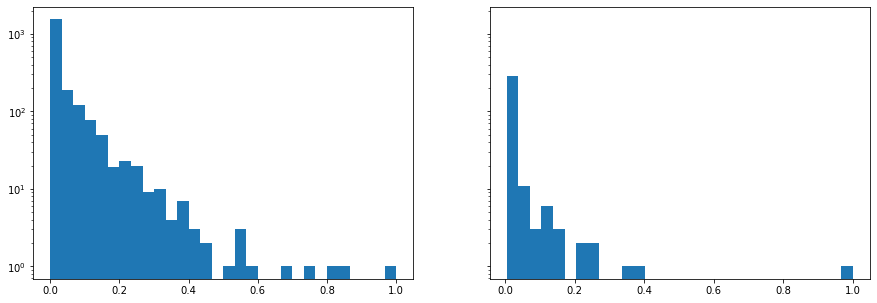

In [138]:
hist_population(sthlmcity_geostat, sthlmcity_homelocations, scale='population_normal', sharey=True)

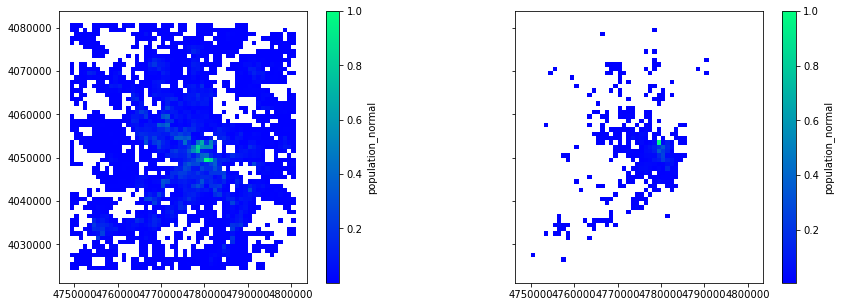

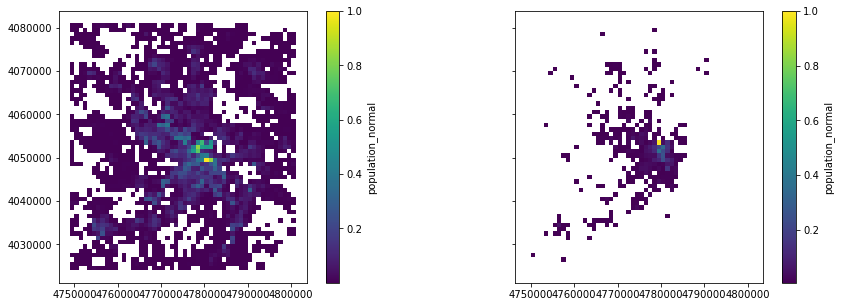

In [172]:
plot_population(sthlmcity_geostat, sthlmcity_homelocations, cmap='winter', scale='population_normal')
plot_population(sthlmcity_geostat, sthlmcity_homelocations, scale='population_normal')

In [141]:
sthlmcity_geostat

,GRD_ID,geometry,population,population_normal,population_pow
0,1kmN4024E4749,"POLYGON ((4749000.000 4024000.000, 4749000.000...",7,0.000268,7.182072e-08
1,1kmN4025E4749,"POLYGON ((4749000.000 4025000.000, 4749000.000...",37,0.001417,2.006583e-06
2,1kmN4027E4749,"POLYGON ((4749000.000 4027000.000, 4749000.000...",3,0.000115,1.319156e-08
3,1kmN4032E4749,"POLYGON ((4749000.000 4032000.000, 4749000.000...",1,0.000038,1.465729e-09
4,1kmN4033E4749,"POLYGON ((4749000.000 4033000.000, 4749000.000...",45,0.001723,2.968101e-06
...,...,...,...,...,...
2080,1kmN4073E4800,"POLYGON ((4800000.000 4073000.000, 4800000.000...",106,0.004058,1.646893e-05
2081,1kmN4074E4800,"POLYGON ((4800000.000 4074000.000, 4800000.000...",57,0.002182,4.762153e-06
2082,1kmN4076E4800,"POLYGON ((4800000.000 4076000.000, 4800000.000...",8,0.000306,9.380665e-08
2083,1kmN4077E4800,"POLYGON ((4800000.000 4077000.000, 4800000.000...",27,0.001034,1.068516e-06


In [149]:
print(sthlmcity_geostat['GRD_ID'].dtype)
print(sthlmcity_homelocations['GRD_ID'].dtype)

object
object


In [159]:
sthlmcity_correlation = sthlmcity_homelocations.merge(sthlmcity_geostat, on='GRD_ID').sort_values('population_y')

In [160]:
sthlmcity_correlation

,GRD_ID,geometry_x,population_x,population_normal_x,population_pow_x,geometry_y,population_y,population_normal_y,population_pow_y
16,1kmN4031E4758,"POLYGON ((4758000.000 4031000.000, 4758000.000...",1,0.005495,0.000030,"POLYGON ((4758000.000 4031000.000, 4758000.000...",1,0.000038,1.465729e-09
12,1kmN4026E4757,"POLYGON ((4757000.000 4026000.000, 4757000.000...",1,0.005495,0.000030,"POLYGON ((4757000.000 4026000.000, 4757000.000...",2,0.000077,5.862916e-09
297,1kmN4067E4782,"POLYGON ((4782000.000 4067000.000, 4782000.000...",1,0.005495,0.000030,"POLYGON ((4782000.000 4067000.000, 4782000.000...",3,0.000115,1.319156e-08
133,1kmN4067E4772,"POLYGON ((4772000.000 4067000.000, 4772000.000...",1,0.005495,0.000030,"POLYGON ((4772000.000 4067000.000, 4772000.000...",4,0.000153,2.345166e-08
58,1kmN4039E4767,"POLYGON ((4767000.000 4039000.000, 4767000.000...",1,0.005495,0.000030,"POLYGON ((4767000.000 4039000.000, 4767000.000...",6,0.000230,5.276624e-08
...,...,...,...,...,...,...,...,...,...
249,1kmN4053E4779,"POLYGON ((4779000.000 4053000.000, 4779000.000...",182,1.000000,1.000000,"POLYGON ((4779000.000 4053000.000, 4779000.000...",17695,0.677450,4.589388e-01
227,1kmN4051E4778,"POLYGON ((4778000.000 4051000.000, 4778000.000...",22,0.120879,0.014612,"POLYGON ((4778000.000 4051000.000, 4778000.000...",19523,0.747435,5.586590e-01
228,1kmN4052E4778,"POLYGON ((4778000.000 4052000.000, 4778000.000...",25,0.137363,0.018868,"POLYGON ((4778000.000 4052000.000, 4778000.000...",21757,0.832963,6.938278e-01
278,1kmN4049E4781,"POLYGON ((4781000.000 4049000.000, 4781000.000...",24,0.131868,0.017389,"POLYGON ((4781000.000 4049000.000, 4781000.000...",21986,0.841730,7.085102e-01


Text(0, 0.5, 'Twitter derived homelocation')

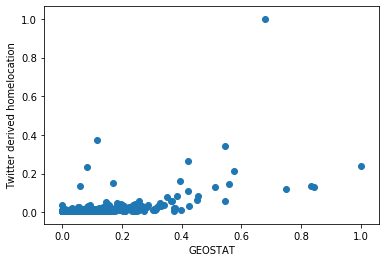

In [168]:
plt.scatter(sthlmcity_correlation['population_normal_y'], sthlmcity_correlation['population_normal_x'])
plt.xlabel('GEOSTAT')
plt.ylabel('Twitter derived homelocation')